In [1]:
%load_ext load_style
%load_style talk.css
from IPython.display import YouTubeVideo, Image

# Wavelets in Python

[Nicolas Fauchereau](mailto:Nicolas.Fauchereau@gmail.com)

This notebook contains quick comparisons of 3 convenient packages implementing wavelet analysis in Python: 
    
+ waipy 
+ kPywavelets
+ wavelets

we will try and reproduce the example in 

[A practical guide to wavelet analysis](http://journals.ametsoc.org/doi/pdf/10.1175/1520-0477%281998%29079%3C0061%3AAPGTWA%3E2.0.CO%3B2)

from Christopher Torrence and Gil P. Compo

using the NINO3.4 seasonal time series

See also the [Interactive Wavelet page](http://ion.exelisvis.com/)

We will also see the example of rectification of the bias that exist in favor of large scales

### references

+ Torrence, C., and G. P. Compo, 1998: [A practical guide to wavelet analysis](http://journals.ametsoc.org/doi/pdf/10.1175/1520-0477%281998%29079%3C0061%3AAPGTWA%3E2.0.CO%3B2). Bull. Amer. Meteor. Soc., 79, 6178.  


+ Liu, Y., X.S. Liang, and R.H. Weisberg, 2007: Rectification of the bias in the wavelet power spectrum. Journal of Atmospheric and Oceanic Technology, 24(12), 2093-2102. [http://ocgweb.marine.usf.edu/~liu/wavelet.html](http://ocgweb.marine.usf.edu/~liu/wavelet.html)

In [4]:
%matplotlib inline
import numpy as np 
from matplotlib import pyplot as plt

### loads the data 

In [5]:
data = np.loadtxt('../data/sst_nino3.dat')

In [6]:
N = data.size

In [7]:
t0=1871
dt=0.25
units='^{\circ}C'
label='NINO3 SST'

In [8]:
time = np.arange(0, N) * dt + t0

## 1. [Waipy](Waipy)

In [7]:
import waipy

In [9]:
data_norm = waipy.normalize(data)

In [12]:
alpha = np.corrcoef(data_norm[0:-1], data_norm[1:])[0,1]; 
print("Lag-1 autocorrelation = {:4.2f}".format(alpha))

Lag-1 autocorrelation = 0.77


In [13]:
result = waipy.cwt(data_norm, 1, 1, 0.25, 2, 4/0.25, alpha, 6, mother='Morlet',name='x')

In [18]:
waipy.wavelet_plot?

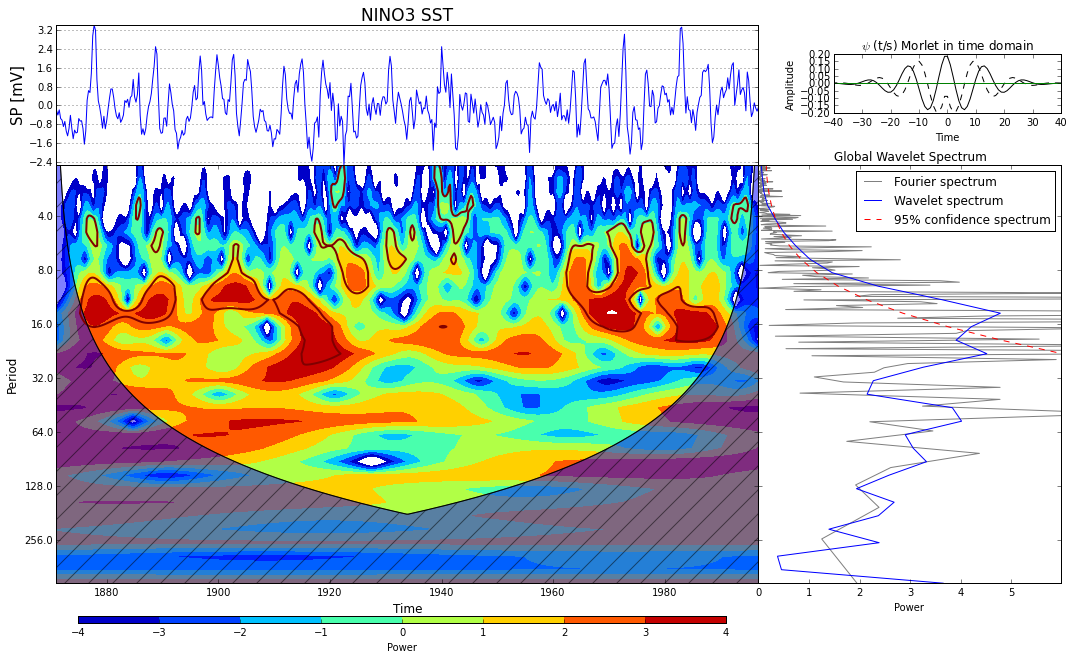

In [32]:
waipy.wavelet_plot(label, time, data_norm, 0.03125, result); 

In [20]:
from waipy import wavelet_plot

In [28]:
wavelet_plot??

## 2. [kPyWavelet](https://github.com/duducosmos/kPyWavelet)

In [25]:
import kPyWavelet as wavelet

In [27]:
slevel = 0.95                        # Significance level

std = data.std()                      # Standard deviation
std2 = std ** 2                      # Variance
var = (data - data.mean()) / std       # Calculating anomaly and normalizing

dj = 0.25                            # Four sub-octaves per octaves
s0 = -1 #2 * dt                      # Starting scale, here 6 months
J = -1 # 7 / dj                      # Seven powers of two with dj sub-octaves

mother = wavelet.Morlet(6.)          # Morlet mother wavelet with wavenumber=6

# The following routines perform the wavelet transform and siginificance
# analysis for the chosen data set.

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(data, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother)
power = (abs(wave)) ** 2             # Normalized wavelet power spectrum
fft_power = std2 * abs(fft) ** 2     # FFT power spectrum
period = 1. / freqs

signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                        significance_level=slevel, wavelet=mother)
sig95 = (signif * np.ones((N, 1))).transpose()
sig95 = power / sig95                # Where ratio > 1, power is significant

# Calculates the global wavelet spectrum and determines its significance level.
glbl_power = std2 * power.mean(axis=1)
dof = N - scales                     # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(std2, dt, scales, 1, alpha,
                       significance_level=slevel, dof=dof, wavelet=mother)

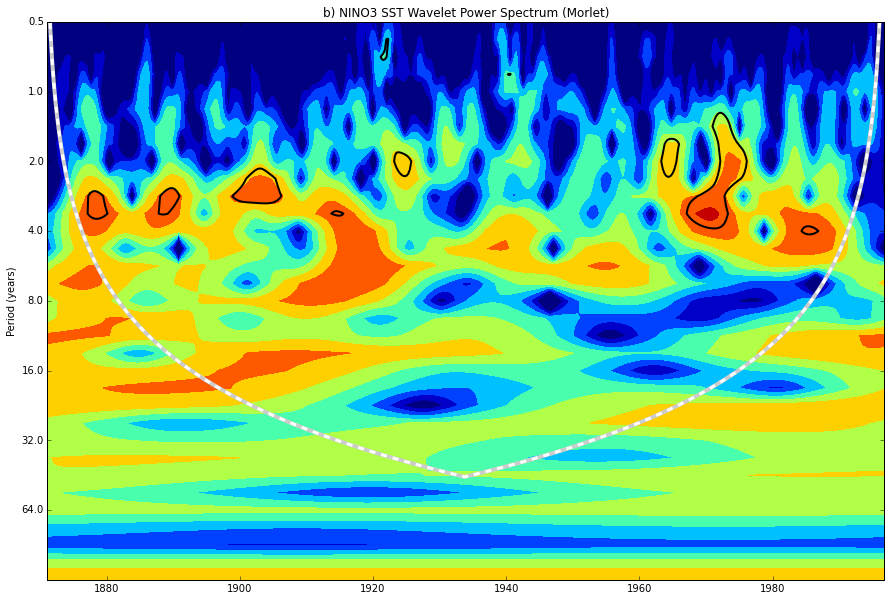

In [35]:
# Second sub-plot, the normalized wavelet power spectrum and significance level
# contour lines and cone of influece hatched area.
f, ax = plt.subplots(figsize=(15,10))
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
ax.contourf(time, np.log2(period), np.log2(power), np.log2(levels),
            extend='both')
ax.contour(time, np.log2(period), sig95, [-99, 1], colors='k',
           linewidths=2.)
#ax.fill(numpy.concatenate([time[:1]-dt, time, time[-1:]+dt, time[-1:]+dt,
#        time[:1]-dt, time[:1]-dt]), numpy.log2(numpy.concatenate([[1e-9], coi,
#        [1e-9], period[-1:], period[-1:], [1e-9]])), 'k', alpha='0.3',
#        hatch='x')

ax.plot(time,np.log2(coi), '0.8', lw=4)

ax.plot(time,np.log2(coi), 'w--', lw=3)
#ax.plot(time,numpy.log2(coi), 'k:', lw=3)

ax.set_title('b) %s Wavelet Power Spectrum (%s)' % (label, mother.name))
ax.set_ylabel('Period (years)')
Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                           np.ceil(np.log2(period.max())))
ax.set_yticks(np.log2(Yticks))
ax.set_yticklabels(Yticks)
ax.invert_yaxis()
ylim = ax.get_ylim()
ax.set_ylim(ylim[0], -1);

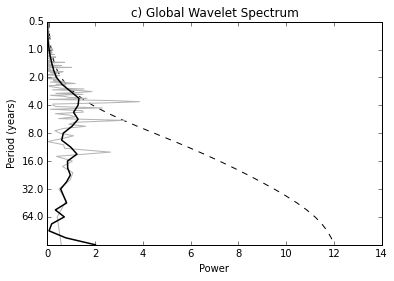

In [37]:
# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra.
f, cx = plt.subplots()
cx.plot(glbl_signif, np.log2(period), 'k--')
cx.plot(fft_power, np.log2(1./fftfreqs), '-', color=[0.7, 0.7, 0.7],
        linewidth=1.)
cx.plot(glbl_power, np.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power')
#cx.set_xlim([0, glbl_power.max() + std2])
cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
cx.set_ylabel('Period (years)')

cx.invert_yaxis()

### 3. wavelet from Torrence and Compo

The implementation is from **Dr. Toru Miyama**

see: 

+ [http://iprc.soest.hawaii.edu/people/miyama.php](http://iprc.soest.hawaii.edu/people/miyama.php)
+ [https://sites.google.com/site/drtorumiyama/](https://sites.google.com/site/drtorumiyama/)

The following is taken from his IPython notebook available at: 

[http://nbviewer.ipython.org/urls/dl.dropbox.com/s/ryeoz3wxrkg1hhz/wavelet_test_ElNino3_Liu.ipynb](http://nbviewer.ipython.org/urls/dl.dropbox.com/s/ryeoz3wxrkg1hhz/wavelet_test_ElNino3_Liu.ipynb)

See also: 

[http://nbviewer.ipython.org/urls/dl.dropbox.com/s/wjch3iysnj6165q/wavelet_test_sine.ipynb](http://nbviewer.ipython.org/urls/dl.dropbox.com/s/wjch3iysnj6165q/wavelet_test_sine.ipynb)

In [39]:
import sys

In [40]:
sys.path.append('./')

In [41]:
from wavelib import *

(1870, 2000)

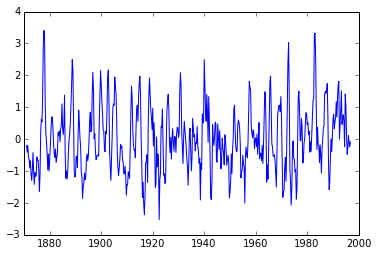

In [42]:
f, ax = plt.subplots()
ax.plot(time,data)
xlim = [1870,2000]  # plotting range
ax.set_xlim(xlim)

In [43]:
variance = np.std(data)**2
mean=np.mean(data)
data = (data - np.mean(data))/np.sqrt(variance)
print "mean=",mean
print "std=", np.sqrt(variance)

mean= 3.52451753849e-18
std= 1.0


#### set wavelet parameters

In [44]:
pad = 1      # pad the time series with zeroes (recommended)
dj = 0.25    # this will do 4 sub-octaves per octave
s0 = 2.*dt    # this says start at a scale of 6 months
j1 = 7./dj    # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72  # lag-1 autocorrelation for red noise background
mother = 'Morlet'

#### wavelet transform

In [45]:
wave,period,scale,coi = wavelet(data,dt,pad,dj,s0,j1,mother);
power = (np.abs(wave))**2         # compute wavelet power spectrum

#### significance levels

In [46]:
signif,fft_theor = wave_signif(1.0,dt,scale,0,lag1,-1,-1,mother)
sig95 = np.dot(signif.reshape(len(signif),1),np.ones((1,N))) # expand signif --> (J+1)x(N) array
sig95 = power / sig95         # where ratio > 1, power is significant

In [47]:
global_ws = variance*power.sum(axis=1)/float(N)   # time-average over all times
dof = N - scale  # the -scale corrects for padding at edges
global_signif,fft_theor = wave_signif(variance,dt,scale,1,lag1,-1,dof,mother)

#### scale-average between 2 and 8 years

In [48]:
avg = (scale >= 2) & (scale < 8)
Cdelta = 0.776;   # this is for the MORLET wavelet
scale_avg = np.dot(scale.reshape(len(scale),1),np.ones((1,N))) # expand scale --> (J+1)x(N) array
scale_avg = power / scale_avg   # [Eqn(24)]
scale_avg = variance*dj*dt/Cdelta*sum(scale_avg[avg,:])   # [Eqn(24)]
scaleavg_signif ,fft_theor= wave_signif(variance,dt,scale,2,lag1,-1,[2,7.9],mother)

In [49]:
iwave=wavelet_inverse(wave, scale, dt, dj, "Morlet")
print "root square mean error",np.sqrt(np.sum((data-iwave)**2)/float(len(data)))*np.sqrt(variance),"deg C"

root square mean error 0.105722742588 deg C


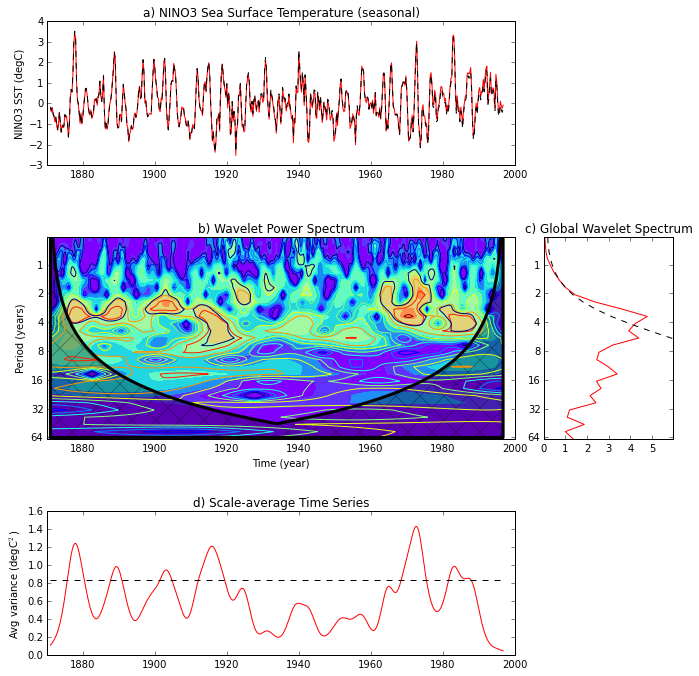

In [55]:
#figure size
fig=plt.figure(figsize=(10,10))

# subplot positions
width= 0.65
hight = 0.28;
pos1a = [0.1, 0.75, width, 0.2]
pos1b = [0.1, 0.37, width, hight]
pos1c = [0.79, 0.37, 0.18, hight]
pos1d = [0.1,  0.07, width, 0.2]

#########################################
#---- a) Original signal
#########################################
ax=fig.add_axes(pos1a)
#original
ax.plot(time,data*np.sqrt(variance)+mean,"r-")
#reconstruction
ax.plot(time,iwave*np.sqrt(variance)+mean,"k--")

ax.set_ylabel('NINO3 SST (degC)')
plt.title('a) NINO3 Sea Surface Temperature (seasonal)')

#########################################
#   b) Wavelet spectrum
#########################################

#--- Contour plot wavelet power spectrum
bx=fig.add_axes(pos1b,sharex=ax)
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16] 
Yticks = 2**(np.arange(np.int(np.log2(np.min(period))),np.int(np.log2(np.max(period)))+1))
bx.contour(time,np.log2(period),np.log2(power),np.log2(levels))
bx.contourf(time,np.log2(period),np.log2(powers),np.log2(levels), extend='both', cmap=plt.get_cmap('rainbow'))
bx.set_xlabel('Time (year)')
bx.set_ylabel('Period (years)')
import matplotlib.ticker as ticker
ymajorLocator=ticker.FixedLocator(np.log2(Yticks))
bx.yaxis.set_major_locator( ymajorLocator )
ticks=bx.yaxis.set_ticklabels(Yticks)
plt.title('b) Wavelet Power Spectrum')

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
cs = bx.contour(time,np.log2(period),sig95,[1],color='k',linewidth=1)

# cone-of-influence, anything "below" is dubious
ts = time;
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
L = bx.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
F=bx.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")

#########################################
#   c) Global Wavelet spectrum
#########################################

#--- Plot global wavelet spectrum
cx=fig.add_axes(pos1c,sharey=bx)
cx.plot(global_ws,np.log2(period),"r-")
cx.plot(global_signif,np.log2(period),'k--')
ylim=cx.set_ylim(np.log2([period.min(),period.max()]))
cx.invert_yaxis()
plt.title('c) Global Wavelet Spectrum')
xrangec=cx.set_xlim([0,1.25*np.max(global_ws)])

#########################################
#   d) Scale average Spectrum
#########################################
#--- Plot Scale-averaged spectrum -----------------
dx=fig.add_axes(pos1d,sharex=bx)
dx.plot(time,scale_avg,"r-")
dx.plot([time[0],time[-1]],[scaleavg_signif,scaleavg_signif],"k--")
xrange=dx.set_xlim(xlim)
dx.set_ylabel('Avg variance (degC$^2$)')
title=plt.title('d) Scale-average Time Series')
plt.savefig("nino3_TorrenceCompo.png")

#### Bias rectification

divides by scales

In [52]:
########################
#  Spectrum
########################
powers=np.zeros_like(power)
for k in range(len(scale)):
    powers[k,:] = power[k,:]/scale[k]
#significance: sig95 is already normalized = 1

########################
#  Spectrum
########################
global_wss = global_ws/scale   
global_signifs=global_signif/scale

########################
#  Scale-average between El Nino periods of 2--8 years
########################
# No need to change 
# because in Eqn(24) of Torrence and Compo [1998], division by scale has been done.
scale_avgs=scale_avg
scaleavg_signifs=scaleavg_signif

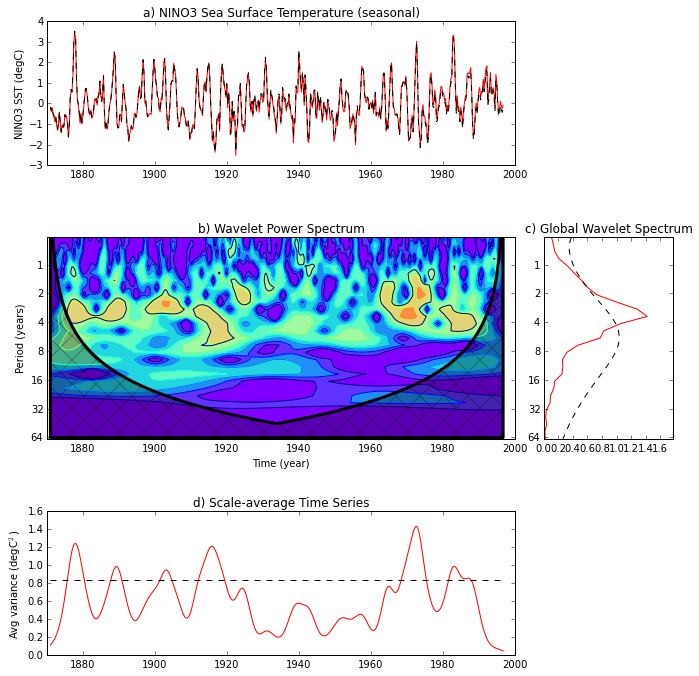

In [53]:
#figure size
fig=plt.figure(figsize=(10,10))

# subplot positions
width= 0.65
hight = 0.28;
pos1a = [0.1, 0.75, width, 0.2]
pos1b = [0.1, 0.37, width, hight]
pos1c = [0.79, 0.37, 0.18, hight]
pos1d = [0.1,  0.07, width, 0.2]

#########################################
#---- a) Original signal
#########################################
ax=fig.add_axes(pos1a)
#original
ax.plot(time,data*np.sqrt(variance)+mean,"r-")
#reconstruction
ax.plot(time,iwave*np.sqrt(variance)+mean,"k--")

ax.set_ylabel('NINO3 SST (degC)')
plt.title('a) NINO3 Sea Surface Temperature (seasonal)')

#########################################
#   b) Wavelet spectrum
#########################################

#--- Contour plot wavelet power spectrum
bx=fig.add_axes(pos1b,sharex=ax)
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16] 
Yticks = 2**(np.arange(np.int(np.log2(np.min(period))),np.int(np.log2(np.max(period)))+1))
bx.contour(time,np.log2(period),np.log2(powers),np.log2(levels))
bx.contourf(time,np.log2(period),np.log2(powers),np.log2(levels), extend='both', cmap=plt.get_cmap('rainbow'))
bx.set_xlabel('Time (year)')
bx.set_ylabel('Period (years)')
import matplotlib.ticker as ticker
ymajorLocator=ticker.FixedLocator(np.log2(Yticks))
bx.yaxis.set_major_locator( ymajorLocator )
ticks=bx.yaxis.set_ticklabels(Yticks)
plt.title('b) Wavelet Power Spectrum')

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
cs = bx.contour(time,np.log2(period),sig95,[1],color='k',linewidth=1)

# cone-of-influence, anything "below" is dubious
ts = time;
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
L = bx.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
F=bx.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")

#########################################
#   c) Global Wavelet spectrum
#########################################

#--- Plot global wavelet spectrum
cx=fig.add_axes(pos1c,sharey=bx)
cx.plot(global_wss,np.log2(period),"r-")
cx.plot(global_signifs,np.log2(period),'k--')
ylim=cx.set_ylim(np.log2([period.min(),period.max()]))
cx.invert_yaxis()
plt.title('c) Global Wavelet Spectrum')
xrangec=cx.set_xlim([0,1.25*np.max(global_wss)])

#########################################
#   d) Global Wavelet spectrum
#########################################
#--- Plot Scale-averaged spectrum -----------------
dx=fig.add_axes(pos1d,sharex=bx)
dx.plot(time,scale_avgs,"r-")
dx.plot([time[0],time[-1]],[scaleavg_signifs,scaleavg_signifs],"k--")
xrange=dx.set_xlim(xlim)
dx.set_ylabel('Avg variance (degC$^2$)')
title=plt.title('d) Scale-average Time Series')